## Разведочный анализ

Подключитесь к базе данных PostgreSQL и выгрузите таблицу `exploratory`, сохранив ее в датафрейм. <br> <br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `db_ds_students`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`.

In [83]:
### YOUR CODE HERE ###
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
%matplotlib inline

pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "db_ds_students",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

# получаем имена таблиц из базы
df_tables = pd.read_sql_query("SELECT table_name FROM information_schema.tables WHERE table_schema='public';", conn)
print('Список таблиц в БД:\n', df_tables)

Список таблиц в БД:
          table_name
0          keywords
1             links
2           ratings
3       exploratory
4  course_purchases


In [65]:
dfe = pd.read_sql_query("SELECT * FROM exploratory;", conn, )
dfe


,feature_1,feature_2,feature_3,feature_4,feature_5
0,2.4399302341553932,-2.180960698389708,33.4684964804719,-1.9273880121739875,-5.3213919475057105
1,1.7705797495879034,-1.174880454210172,0.9895926481354946,-1.1396809115663187,-2.0802195404111687
2,0.7428169764168391,-0.2634829113111655,0.16814863490368492,-0.3324379721161745,-0.19571957951766614
3,-1.510891800324271,2.7125712625192238,-2.6856430298672915,2.0584952423727403,-4.098401678335551
4,-0.4835110394772655,0.096511221663355,-0.028703495808161117,0.1687629004635419,-0.04666424110766956
...,...,...,...,...,...
95,0.10764850635557899,-3.101785656930369,56.49091243959598,-1.9937680914933749,-0.33390259300371256
96,1.759629548272443,-1.4285652188163707,1.2644422383976943,-1.29835370396105,-2.513745570663574
97,0.8438229416103058,1.1876556600977073,-1.4100261703323511,0.566680768339602,1.0021710927237768
98,0.8671537593957526,1.1115564316783124,-1.3317181504522202,0.5131668559607284,0.9638903385103766


In [66]:
dfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   feature_1  100 non-null    object
 1   feature_2  100 non-null    object
 2   feature_3  100 non-null    object
 3   feature_4  100 non-null    object
 4   feature_5  100 non-null    object
dtypes: object(5)
memory usage: 4.0+ KB


In [67]:
# Приводим формат столбцов к числовому
dfe['feature_1'] = dfe['feature_1'].astype('float')
dfe['feature_2'] = dfe['feature_2'].astype('float')
dfe['feature_3'] = dfe['feature_3'].astype('float')
dfe['feature_4'] = dfe['feature_4'].astype('float')

#### Постройте гистограммы распределения для каждой переменной. Поэксперементируйте с количеством "разбивок" (bins). Опишите распределение каждой переменной. В каких областях (пример: от нуля до 2 расположено примерно треть всех значений) сосредоточено больше значений, в каких меньше. 

In [79]:
### YOUR CODE HERE ###
# dfe['feature_1'].hist(bins=20, figsize=(10, 6))

In [119]:
# Использую наработки из курса по мат. статистике
def find_anomaly(df, column, level=95):
    level_col = np.percentile(df[column], level)
    anomaly = df[(df[column] >= level_col)][column]
    return anomaly, level_col

def my_stat_info(df, column, bins=10, alevel=95):
    print('График по столбцу', column)

    descr = df[column].describe()
    m_count, m_mean, m_std, m_min, m_25, m_50, m_75, m_max = np.round(descr, 3)
    m_alevel = np.percentile(df[column], alevel)
    print('Базовые данные:', f'\nсреднее={m_mean}, дисперсия={m_std}, 25%={m_25}, 50%={m_50}, 75%={m_75}, {alevel}%={m_alevel}, max={m_max}')
    print(f'ассиметрия: {round(skew(df[column]), 3)}, эксцесс: {round(kurtosis(df[column]), 3)}' )
    print(f'ТОП 5 значений:\n{df[column].value_counts().nlargest(5).to_string()}')

    anomaly, level_col = find_anomaly(df, column, level=alevel)
    print('Обнаружено аномалий:', anomaly.count())

    plt.figure(figsize=(14,6))
    plt.title("Столбец '"+column+"'")
    try:
        sns.distplot(df[column], bins=bins, )
    except RuntimeError:
        print('Не могу нарисовать красивый график через sns.distplot, использую обычный hist()')
        df[column].hist()
    plt.axvline(x=m_min, color="r", linestyle="-", label='min')
    plt.axvline(x=m_max, color="r", linestyle="-", label='max')
    plt.axvline(x=m_mean, color="g", linestyle="-", lw=4, label='mean')
    plt.axvline(x=m_50, color="b", linestyle="--", label='50')
    plt.axvline(x=m_alevel, color="k", linestyle="-", label=f'{alevel}%')
    plt.legend()
    plt.grid()
    plt.show()

График по столбцу feature_1
Базовые данные: 
среднее=-0.065, дисперсия=1.249, 25%=-1.077, 50%=0.172, 75%=0.879, 95%=1.7736572180890717, max=2.44
ассиметрия: -0.166, эксцесс: -0.922
ТОП 5 значений:
 0.506685    1
-1.547069    1
-1.467589    1
 0.569660    1
 0.463906    1
Обнаружено аномалий: 5


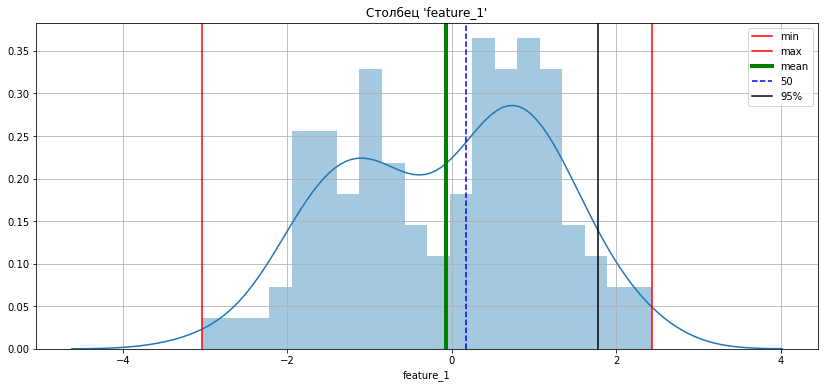

In [120]:
# plt.figure(figsize=(10, 6))
# ax = sns.distplot(dfe.feature_1, kde=True, bins=20, )
# plt.grid()
# print(dfe['feature_1'].describe())
my_stat_info(dfe, 'feature_1', bins=20, alevel=95)

Распределение похоже на сложение двух нормальных. Основной объем данных сосредоточен в интервале от -2 до 2. Коэффициент ассиметрии по модулю меньше 0.25, значит ассиметрия незначительна.

График по столбцу feature_2
Базовые данные: 
среднее=0.038, дисперсия=1.42, 25%=-1.099, 50%=0.0, 75%=1.187, 95%=2.1420274267150554, max=2.713
ассиметрия: -0.151, эксцесс: -0.755
ТОП 5 значений:
 1.934081    1
-0.640932    1
 1.445821    1
-1.502267    1
 2.134806    1
Обнаружено аномалий: 5


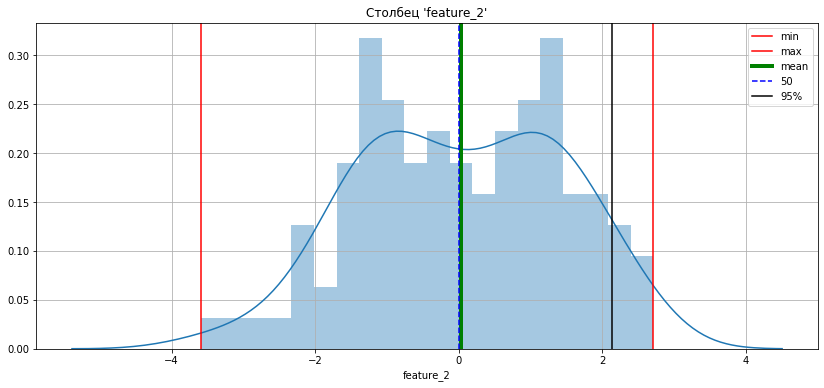

In [121]:
my_stat_info(dfe, 'feature_2', bins=20, alevel=95)

Распределение похоже на сложение двух нормальных. Основной объем данных сосредоточен в интервале от -2 до 2. Коэффициент ассиметрии по модулю меньше 0.25, значит ассиметрия незначительна.

График по столбцу feature_3
Базовые данные: 
среднее=3.959, дисперсия=13.3, 25%=-1.215, 50%=-0.047, 75%=1.089, 90%=4.725092897126717, max=62.382
ассиметрия: 2.926, эксцесс: 7.403
ТОП 5 значений:
-0.891736     1
 62.381761    1
 49.340662    1
 0.480690     1
 0.862682     1
Обнаружено аномалий: 10


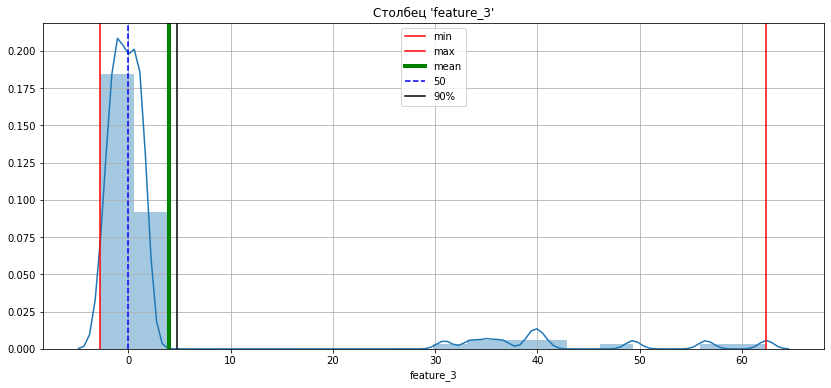

In [126]:
my_stat_info(dfe, 'feature_3', bins=20, alevel=90)

Распределение не похоже на нормальное. Основные данные распределены в интервале от -1 до 5. Имеются выбросы в интервале от 30 до 63.

График по столбцу feature_4
Базовые данные: 
среднее=0.038, дисперсия=1.03, 25%=-0.779, 50%=0.001, 75%=0.886, 95%=1.634294491797493, max=2.086
ассиметрия: -0.095, эксцесс: -0.71
ТОП 5 значений:
 0.802656    1
-0.418281    1
-0.673094    1
 1.122223    1
 0.382564    1
Обнаружено аномалий: 5


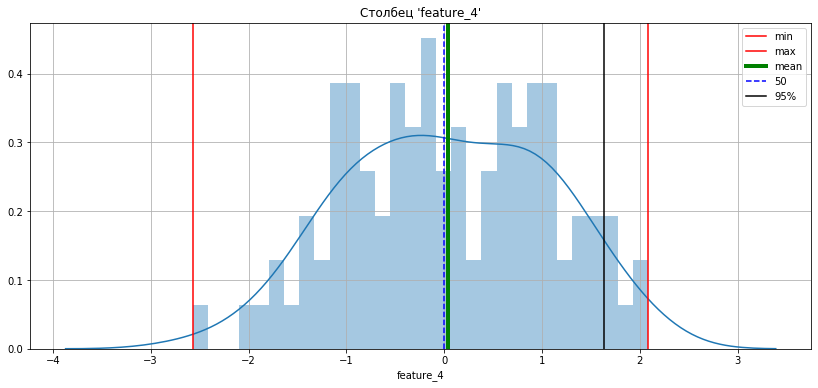

In [128]:
my_stat_info(dfe, 'feature_4', bins=30, alevel=95)

Распределение похоже на нормальное. Основной объем данных в интервале от -0.78 до 0.89. Коэффициент ассиметрии по модулю меньше 0.25, значит ассиметрия незначительна. Исходя из коэффициента эксцесса, распределение чуть более пологое чем нормальное.

#### Постройте ящик с усами для каждой переменной. Опишите распределение данных. Прокомментируйте наличие или отсутствие выбросов.

In [139]:
### YOUR CODE HERE ###
dfe.boxplot(vert=False, figsize=(16, 6))
# sns.boxplot(dfe.feature_1)

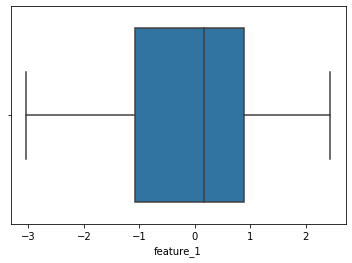

In [141]:
sns.boxplot(dfe.feature_1)

Основной массив данныех (с 25 по 75 перцентиль) расположен в интервале от -1 до 1. Медиана чуть правее 0. Размах данных от -3 до 2.5. Выбросов минимальное количество

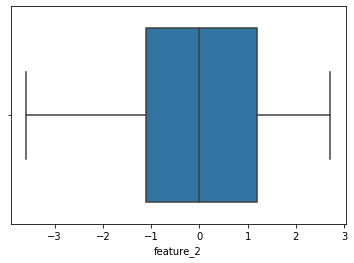

In [142]:
sns.boxplot(dfe.feature_2)

Основной массив данныех (с 25 по 75 перцентиль) расположен в интервале чуть большем чем от -1 до 1. Медиана чуть левее 0. Размах данных от -3.7 до 2.8. Выбросов минимальное количество

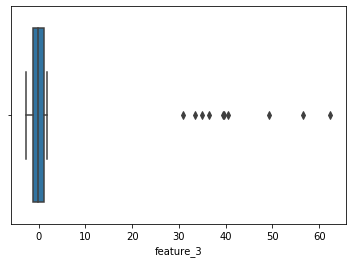

In [146]:
sns.boxplot(dfe.feature_3)

Основной массив данныех (с 25 по 75 перцентиль) расположен в интервале около 0. Есь выбросы в интервале от 30 до 65

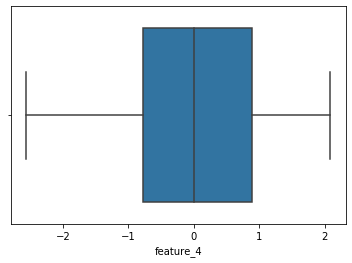

In [147]:
sns.boxplot(dfe.feature_4)

Основной массив данных (с 25 по 75 перцентиль) расположен в интервале от -1 до 1. Медиана около 0. Размах данных от -3 до 2.1. Выбросов минимальное количество

Допустим, мы хотим построить регрессионную модель по имеющимся данным и исследовать влияние остальных переменных на переменную `feature_4`. Постройте диаграммы рассеяния. Определите по графикам, какие независимые переменные имело бы смысл включить в модель регрессии?

In [ ]:
### YOUR CODE HERE ###

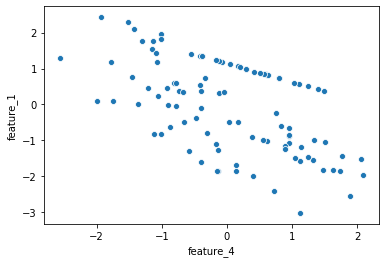

In [148]:
sns.scatterplot(dfe.feature_4, dfe.feature_1)

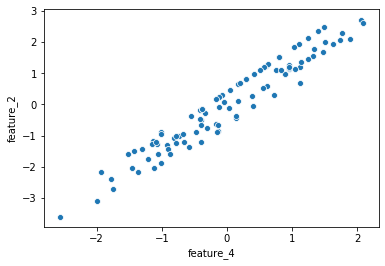

In [149]:
sns.scatterplot(dfe.feature_4, dfe.feature_2)

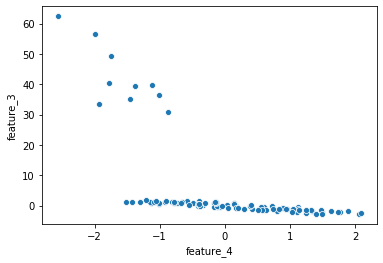

In [150]:
sns.scatterplot(dfe.feature_4, dfe.feature_3)

Видна явная корелляция с feature_2. Ее явно включать не надо. Думаю, будет в анализ интересно включить фичу 3. Возможно, фичу 1. Хотя, там тоже просматривается корреляция.
Значит, включаем фичу 3.